In [1]:
import torch
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [3]:
from datasets import get_dataset

Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

num_workers_3dshapes = 4
data_loader = DataLoader(shapes3d_dataset, 
                         batch_size=64, 
                         shuffle=True, 
                         num_workers=num_workers_3dshapes, 
                         pin_memory=True,
                         persistent_workers=True
                         )

# SN-GAN Implementation
This notebook implements a Spectral Normalization GAN (SN-GAN) using architectures inspired by the Locatello VAE model.

In [4]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm, trange


# Generator (based on Locatello's Decoder)
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim=10):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim

        kernel_size = 4
        n_chan = self.img_size[0]
        self.reshape = (64, kernel_size, kernel_size)

        self.lin1 = nn.Linear(latent_dim, 256)
        self.lin2 = nn.Linear(256, np.prod(self.reshape))

        cnn_kwargs = dict(stride=2, padding=1)
        self.convT1 = nn.ConvTranspose2d(64, 64, kernel_size, **cnn_kwargs)
        self.convT2 = nn.ConvTranspose2d(64, 32, kernel_size, **cnn_kwargs)
        self.convT3 = nn.ConvTranspose2d(32, 32, kernel_size, **cnn_kwargs)        
        self.convT4 = nn.ConvTranspose2d(32, n_chan, kernel_size, **cnn_kwargs)

    def forward(self, z):
        batch_size = z.size(0)
        x = torch.nn.functional.leaky_relu(self.lin1(z), 0.2)
        x = torch.nn.functional.leaky_relu(self.lin2(x), 0.2)
        x = x.view(batch_size, *self.reshape)
        x = torch.nn.functional.leaky_relu(self.convT1(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.convT2(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.convT3(x), 0.2)
        return torch.sigmoid(self.convT4(x)) # Use sigmoid for image output

# Discriminator (based on Locatello's Encoder with Spectral Normalization)
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size

        kernel_size = 4
        n_chan = self.img_size[0]

        assert_str = "This architecture requires 64x64 inputs."
        assert self.img_size[-2] == self.img_size[-1] == 64, assert_str

        cnn_kwargs = dict(stride=2, padding=1)
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(n_chan, 32, kernel_size, **cnn_kwargs))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(32, 32, kernel_size, **cnn_kwargs))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(32, 64, kernel_size, **cnn_kwargs))
        self.conv4 = nn.utils.spectral_norm(nn.Conv2d(64, 64, kernel_size, **cnn_kwargs))

        self.lin = nn.utils.spectral_norm(nn.Linear(int((64/(2**4))**2 * 64), 256))
        self.output_layer = nn.utils.spectral_norm(nn.Linear(256, 1)) # Output a single value for real/fake

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.nn.functional.leaky_relu(self.conv1(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.conv2(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.conv3(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.conv4(x), 0.2)
        x = x.view((batch_size, -1))
        x = torch.nn.functional.leaky_relu(self.lin(x), 0.2)
        return self.output_layer(x)

In [5]:
# Initialize Generator and Discriminator
img_size = (3, 64, 64)  # Assuming RGB images of size 64x64
gen = Generator(img_size, latent_dim=10).to(device)
disc = Discriminator(img_size).to(device)

# Optimizers
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
num_epochs = 5
d_steps = 1 # Discriminator steps per generator step
g_steps = 1 # Generator steps per discriminator step

# Training Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (real_images, _) in enumerate(data_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Train Discriminator
        for _ in range(d_steps):
            disc_optimizer.zero_grad()
            
            # Real images
            real_output = disc(real_images)
            d_loss_real = torch.mean(torch.relu(1. - real_output))
            
            # Fake images
            z = torch.randn(batch_size, gen.latent_dim).to(device)
            fake_images = gen(z).detach()
            fake_output = disc(fake_images)
            d_loss_fake = torch.mean(torch.relu(1. + fake_output))
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            disc_optimizer.step()
            
        # Train Generator
        for _ in range(g_steps):
            gen_optimizer.zero_grad()
            z = torch.randn(batch_size, gen.latent_dim).to(device)
            fake_images = gen(z)
            output = disc(fake_images)
            g_loss = -torch.mean(output) # Generator tries to make fake images look real
            g_loss.backward()
            gen_optimizer.step()
            
        # Print progress every 100 batches
        if (i+1) % 500 == 0:
            print(f"  Batch {i+1}/{len(data_loader)}, D_Loss: {d_loss.item():.4f}, G_Loss: {g_loss.item():.4f}")

print("Training complete!")

Epoch 1/5
  Batch 500/7500, D_Loss: 0.0000, G_Loss: 1.1351
  Batch 1000/7500, D_Loss: 0.1240, G_Loss: 2.2015
  Batch 1500/7500, D_Loss: 0.5060, G_Loss: 0.9838
  Batch 2000/7500, D_Loss: 0.4827, G_Loss: 2.5806
  Batch 2500/7500, D_Loss: 0.2654, G_Loss: 2.3300
  Batch 3000/7500, D_Loss: 0.0640, G_Loss: 0.9637
  Batch 3500/7500, D_Loss: 0.0795, G_Loss: 2.0182
  Batch 4000/7500, D_Loss: 0.0000, G_Loss: 1.1002
  Batch 4500/7500, D_Loss: 0.8884, G_Loss: 1.0124
  Batch 5000/7500, D_Loss: 0.0020, G_Loss: 1.6638
  Batch 5500/7500, D_Loss: 0.0510, G_Loss: 1.3576
  Batch 6000/7500, D_Loss: 0.5733, G_Loss: 1.9409
  Batch 6500/7500, D_Loss: 0.4755, G_Loss: 1.6780
  Batch 7000/7500, D_Loss: 0.1681, G_Loss: 3.4173
  Batch 7500/7500, D_Loss: 0.4190, G_Loss: 1.7137
Epoch 2/5
  Batch 500/7500, D_Loss: 0.1375, G_Loss: 1.6212
  Batch 1000/7500, D_Loss: 0.3695, G_Loss: 1.2078
  Batch 1500/7500, D_Loss: 0.1692, G_Loss: 1.3569
  Batch 2000/7500, D_Loss: 0.3134, G_Loss: 2.0676
  Batch 2500/7500, D_Loss: 0.035

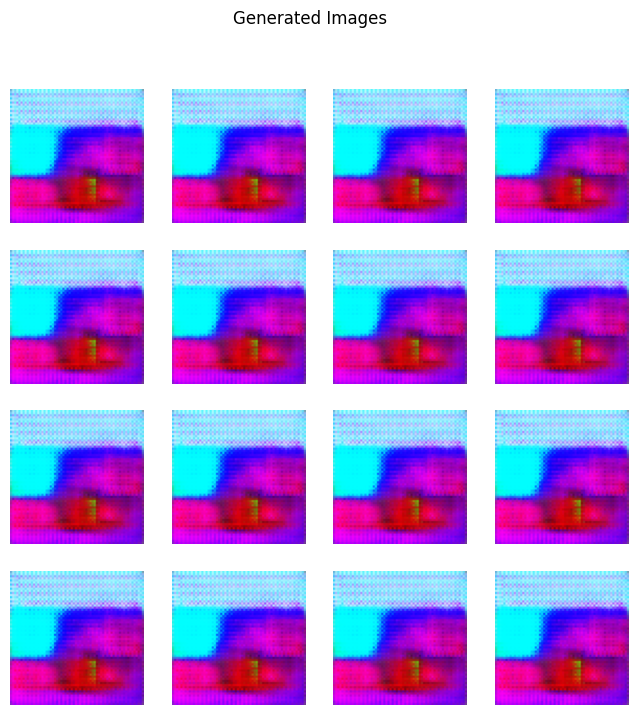

In [7]:
import matplotlib.pyplot as plt

# Generate some fake images for visualization
num_images_to_show = 16
z_sample = torch.randn(num_images_to_show, gen.latent_dim).to(device)
with torch.no_grad():
    generated_images = gen(z_sample).cpu()

# Plot the generated images
fig = plt.figure(figsize=(8, 8))
for i in range(num_images_to_show):
    ax = fig.add_subplot(4, 4, i + 1)
    img = generated_images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis('off')
plt.suptitle("Generated Images")
plt.show()